In [902]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
from statsmodels.api import OLS, add_constant
import pandas_datareader.data as pdr
from pandas_datareader.famafrench import get_available_datasets
import yfinance as yf
import datetime as dt

from linearmodels.asset_pricing import LinearFactorModel

def FF_betas(returns, ff_factor_data, single_asset=False):
    betas = []
    if single_asset == False:
        for asset in returns:
            # Time series regression of industry portfolio returns on FF5 factor returns --> get Factor Exposures (Betas)
            step1 = OLS(endog=returns.loc[ff_factor_data.index, asset], 
                        exog=add_constant(ff_factor_data)
                        ).fit()
            betas.append(step1.params.drop('const'))
            
        betas = pd.DataFrame(betas, 
                         columns=ff_factor_data.columns, 
                         index=returns.columns)
    else:
        step1 = OLS(endog=returns.loc[ff_factor_data.index], 
                    exog=add_constant(ff_factor_data)
                    ).fit()
        betas = pd.DataFrame(step1.params.drop('const'), columns=[returns.name])
        
    return betas

def FF_lambdas(returns, betas):
    lambdas = []
    for period in returns.index:
        step2 = OLS(endog=returns.loc[period, betas.index],
                    exog=betas # add constant = risk_free
                    ).fit()
        lambdas.append(step2.params)
    lambdas = pd.DataFrame(lambdas, 
                           index=returns.index,
                           columns=betas.columns.tolist())
    return lambdas

In [903]:
### Search FF datasets 

# get list of FF dataset names
datasets = get_available_datasets()

# search for relevant dataset
search_keyword_1 = 'Research'
search_keyword_2 = ''
search_result = [dataset for dataset in datasets if (search_keyword_1 in dataset) and (search_keyword_2 in dataset)]
print(search_result)

['F-F_Research_Data_Factors', 'F-F_Research_Data_Factors_weekly', 'F-F_Research_Data_Factors_daily', 'F-F_Research_Data_5_Factors_2x3', 'F-F_Research_Data_5_Factors_2x3_daily']


In [934]:
# daily 5 factor data
ff_factor = 'F-F_Research_Data_5_Factors_2x3_daily'
# get max period of FF data
end = dt.datetime.now()
ff_factor_data = pdr.DataReader(ff_factor, 'famafrench', start='1900-01', end=end)[0]
end_date = ff_factor_data.iloc[-1].name

# sample 100 companies from the S&P500 constituents
sample_size = 100 # Lever to change
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_constituents = pd.read_html(url, header=0)[0]
sample_tickers = sp500_constituents.Symbol.sample(n=sample_size, random_state=42).values.tolist()
sample_tickers = [tkr.replace('.','-') if '.' in tkr else tkr for tkr in sample_tickers]

# get stock price and calculate returns
stock_prices = yf.download(sample_tickers, 
                           start='1900-01-01',
                           end=end,
                           interval='1d', progress=False)['Adj Close'].dropna()
stock_returns = stock_prices.pct_change(1).dropna().loc[:end] * 100

print(
    'FF data dates that do not exist in stock returns data dates:',
    len(set(ff_factor_data.index) - set(stock_returns.index)), \
    '\nstock returns data dates that do not exist in FF data dates',
    len(set(stock_returns.index) - set(ff_factor_data.index))
)

# adjust FF data to match data for stock returns
ff_factor_adj = pd.concat([ff_factor_data, stock_returns], axis=1).dropna()[ff_factor_data.columns]
stock_returns_adj = pd.concat([ff_factor_data, stock_returns], axis=1).dropna()[stock_returns.columns]
# calculate excess stock returns of risk-free rate, drop RF column
stock_returns_adj = stock_returns_adj.sub(ff_factor_adj.RF, axis=0)
ff_factor_adj = ff_factor_adj.drop('RF', axis=1)

stock_returns_adj.info()
ff_factor_adj.info()

FF data dates that do not exist in stock returns data dates: 14462 
stock returns data dates that do not exist in FF data dates 63
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 661 entries, 2020-12-11 to 2023-07-31
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ABNB    661 non-null    float64
 1   ABT     661 non-null    float64
 2   AFL     661 non-null    float64
 3   ALB     661 non-null    float64
 4   ALLE    661 non-null    float64
 5   ANET    661 non-null    float64
 6   ANSS    661 non-null    float64
 7   AVGO    661 non-null    float64
 8   AWK     661 non-null    float64
 9   AXON    661 non-null    float64
 10  AXP     661 non-null    float64
 11  BK      661 non-null    float64
 12  BKNG    661 non-null    float64
 13  BLK     661 non-null    float64
 14  BMY     661 non-null    float64
 15  BR      661 non-null    float64
 16  BRK-B   661 non-null    float64
 17  BRO     661 non-null    float64
 18 

In [935]:
# calculate betas and lambdas of 5 factors
stock_betas = FF_betas(stock_returns_adj, ff_factor_adj)
stock_lambdas = FF_lambdas(stock_returns_adj, stock_betas)

In [936]:
stock_betas.T

,ABNB,ABT,AFL,ALB,ALLE,ANET,ANSS,AVGO,AWK,AXON,...,VICI,VRSK,VTRS,WDC,WELL,WRK,WTW,XYL,YUM,ZBH
Mkt-RF,1.313424,0.749739,0.934682,1.280758,1.004116,1.182889,1.182984,1.253602,0.676522,0.873185,...,0.838528,0.737721,0.888557,1.437282,0.759194,1.150359,0.840403,1.069758,0.714765,0.794159
SMB,0.426782,-0.287232,-0.059340,0.653060,0.461139,-0.070553,-0.138956,0.031330,-0.320753,0.775655,...,0.090308,-0.129525,0.120151,0.586327,0.158562,0.532899,-0.103687,0.278219,-0.116358,0.097354
HML,-0.204563,-0.285346,0.757474,0.540196,0.055156,-0.355676,-0.576768,-0.500488,-0.339729,-0.955028,...,0.133544,-0.370527,0.407671,0.181345,0.236450,0.839941,0.050168,0.073521,0.010724,0.060370
RMW,-0.917122,0.082472,-0.047475,-0.643212,0.636775,0.093847,-0.021969,0.234616,0.315208,-0.072984,...,-0.185851,0.372464,-0.167331,0.108546,0.133995,0.376499,0.118656,0.371826,0.185707,0.034229
CMA,-0.037904,0.393229,-0.046747,-0.488727,-0.117628,-0.106019,-0.216438,0.384155,0.395484,0.266762,...,0.182285,0.098491,0.076096,0.209591,0.075256,-0.271017,0.138581,-0.083345,0.101722,0.050389


### 5 factor historical performance within the sampled companies

agg_beta: 55% def_beta: 45%


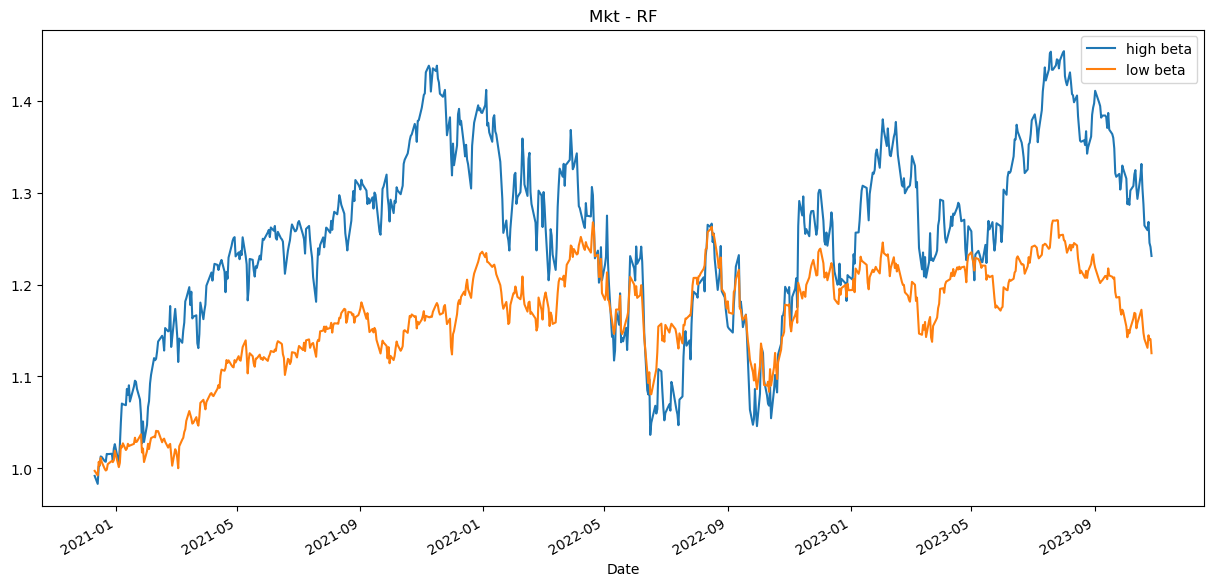

In [937]:
### Mkt - RF
fig,ax = plt.subplots(figsize=(15,7))
agg_beta = stock_betas[stock_betas['Mkt-RF'].gt(1)].index
def_beta = stock_betas[stock_betas['Mkt-RF'].le(1)].index
agg_beta_r = (1+(stock_returns[agg_beta]/100).mean(axis=1)).cumprod()
agg_beta_r.plot(label='high beta')
def_beta_r = (1+(stock_returns[def_beta]/100).mean(axis=1)).cumprod()
def_beta_r.plot(label='low beta')
plt.title('Mkt - RF')
plt.legend();

print(f'agg_beta: {round(100 * len(agg_beta)/len(stock_betas.index))}%',
      f'def_beta: {round(100 * len(def_beta)/len(stock_betas.index))}%')

# high beta stocks tend to overperform the low beta stocks

small_cap: 63% large_cap: 37%


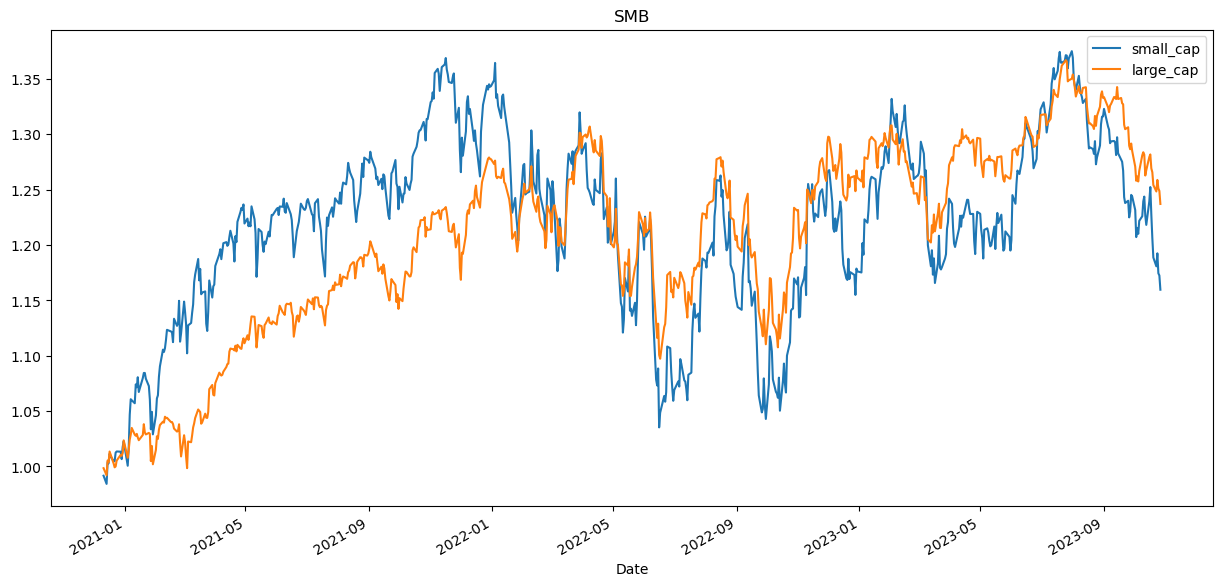

In [942]:
### SMB
fig,ax = plt.subplots(figsize=(15,7))
small_cap = stock_betas[stock_betas['SMB'].gt(0)].index
large_cap = stock_betas[stock_betas['SMB'].le(0)].index
small_cap_r = (1+(stock_returns[small_cap]/100).mean(axis=1)).cumprod()
small_cap_r.plot(label='small_cap')
large_cap_r = (1+(stock_returns[large_cap]/100).mean(axis=1)).cumprod()
large_cap_r.plot(label='large_cap')
plt.title('SMB')
plt.legend();

print(f'small_cap: {round(100 * len(small_cap)/len(stock_betas.index))}%',
      f'large_cap: {round(100 * len(large_cap)/len(stock_betas.index))}%')

# large cap stocks tend to slightly over perform the small cap stocks recently

value: 62% growth: 38%


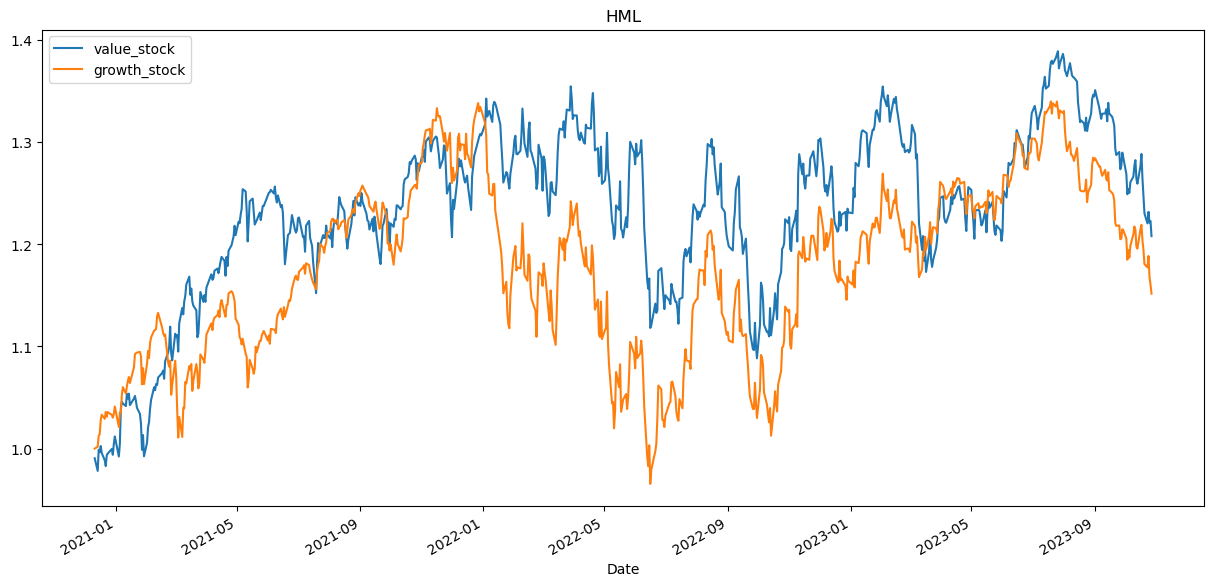

In [943]:
### HML
fig,ax = plt.subplots(figsize=(15,7))
value = stock_betas[stock_betas['HML'].gt(0)].index
growth = stock_betas[stock_betas['HML'].le(0)].index
value_r = (1+(stock_returns[value]/100).mean(axis=1)).cumprod()
value_r.plot(label='value_stock')
growth_r = (1+(stock_returns[growth]/100).mean(axis=1)).cumprod()
growth_r.plot(label='growth_stock')
plt.title('HML')
plt.legend();

print(f'value: {round(100 * len(value)/len(stock_betas.index))}%',
      f'growth: {round(100 * len(growth)/len(stock_betas.index))}%')

# value stock tend to slghtly overperform the growth stocks recently

robust_profit: 64% weak_profit: 36%


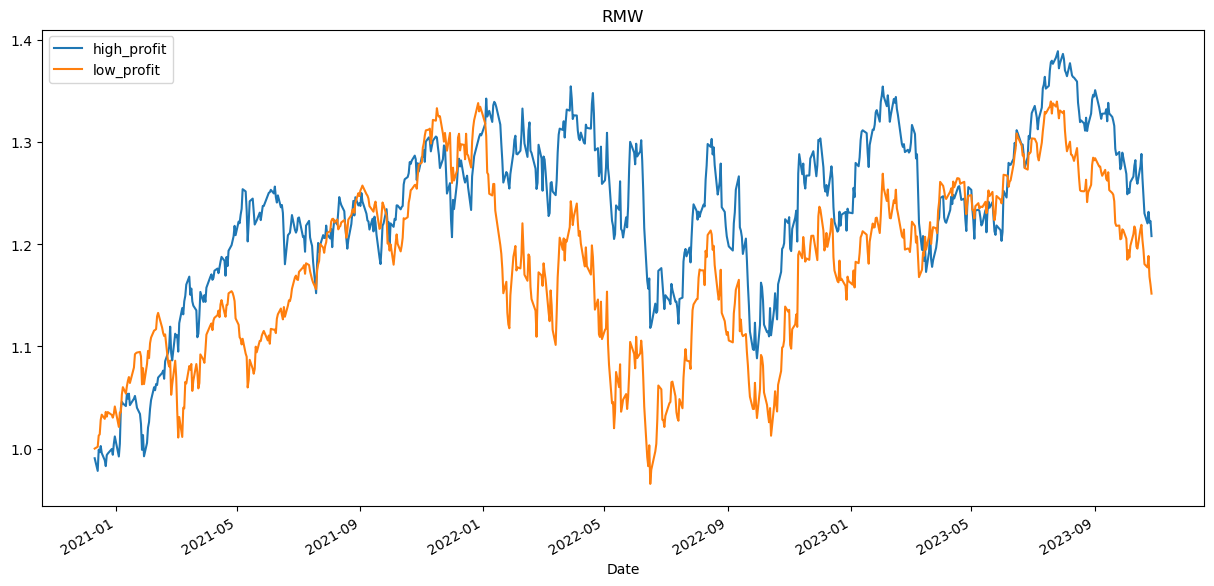

In [944]:
### RMW
fig,ax = plt.subplots(figsize=(15,7))
robust_profit = stock_betas[stock_betas['RMW'].gt(0)].index
weak_profit = stock_betas[stock_betas['RMW'].le(0)].index
robust_profit_r = (1+(stock_returns[value_stock]/100).mean(axis=1)).cumprod()
robust_profit_r.plot(label='high_profit')
weak_profit_r = (1+(stock_returns[growth_stock]/100).mean(axis=1)).cumprod()
weak_profit_r.plot(label='low_profit')
plt.title('RMW')
plt.legend();

print(f'robust_profit: {round(100 * len(robust_profit)/len(stock_betas.index))}%',
      f'weak_profit: {round(100 * len(weak_profit)/len(stock_betas.index))}%')

# robust profit stocks tend to slghtly overperform the weak profit stocks

conservative_INV: 54% aggressive_INV: 46%


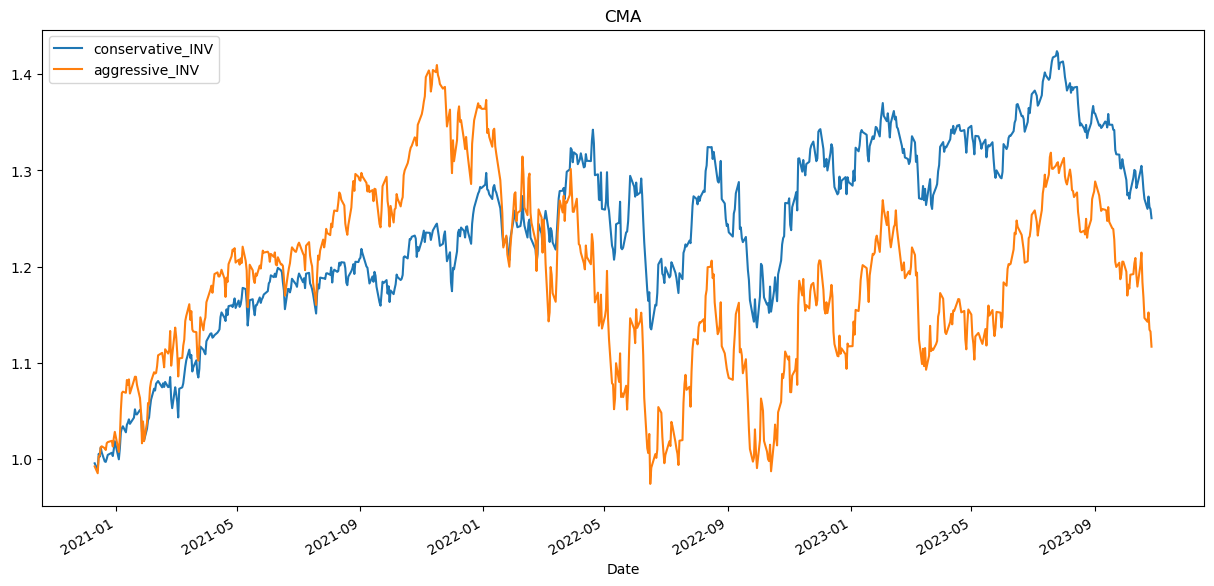

In [945]:
### CMA
fig,ax = plt.subplots(figsize=(15,7))
conservative_INV = stock_betas[stock_betas['CMA'].gt(0)].index
aggressive_INV = stock_betas[stock_betas['CMA'].le(0)].index
conservative_INV_r = (1+(stock_returns[conservative_INV]/100).mean(axis=1)).cumprod()
conservative_INV_r.plot(label='conservative_INV')
aggressive_INV_r = (1+(stock_returns[aggressive_INV]/100).mean(axis=1)).cumprod()
aggressive_INV_r.plot(label='aggressive_INV')
plt.title('CMA')
plt.legend();

print(f'conservative_INV: {round(100 * len(conservative_INV)/len(stock_betas.index))}%',
      f'aggressive_INV: {round(100 * len(aggressive_INV)/len(stock_betas.index))}%')

# conservative investment stocks tend to overperform the aggressive investment stocks recently

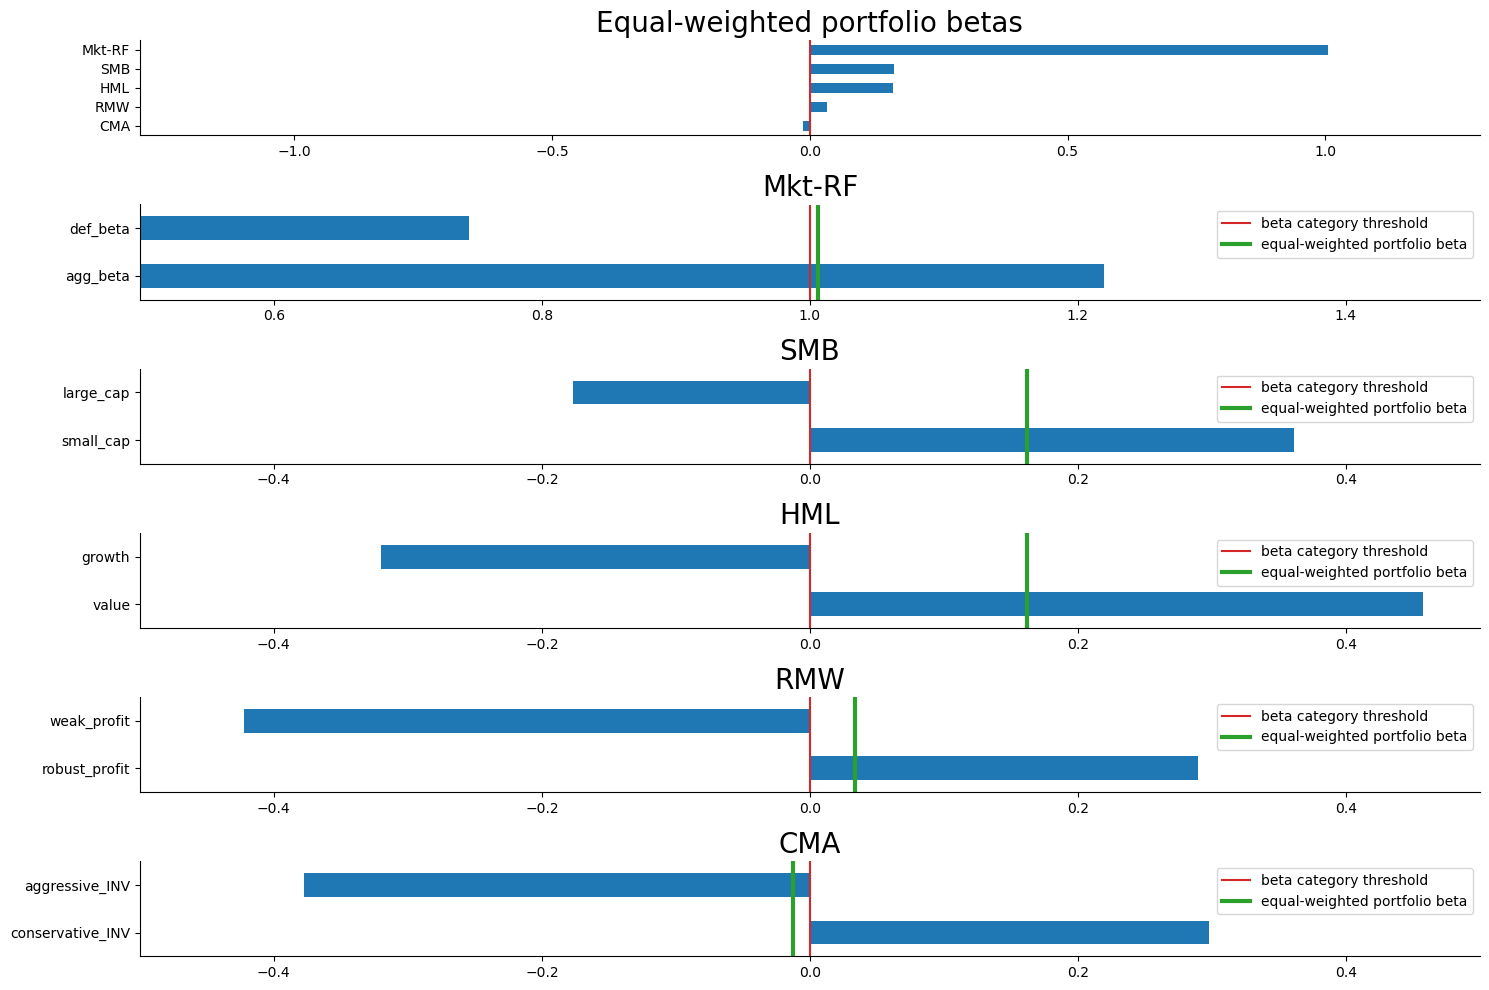

In [946]:
# factor exposures analysis

factor_cats = {
    'Mkt-RF':['agg_beta','def_beta'],
    'SMB':['small_cap','large_cap'],
    'HML':['value','growth'], 
    'RMW':['robust_profit','weak_profit'],
    'CMA':['conservative_INV','aggressive_INV']
} 

cat_elements = {
    'agg_beta':agg_beta,
    'def_beta':def_beta,

    'small_cap':small_cap,
    'large_cap':large_cap,

    'value':value,
    'growth':growth,

    'robust_profit':robust_profit,
    'weak_profit':weak_profit,

    'conservative_INV':conservative_INV,
    'aggressive_INV':aggressive_INV
}

# equal weighted portfolio betas
eqw_pf_betas = stock_betas.T.mean(axis=1)

fig,ax = plt.subplots(6,1, figsize=(15, 10))
width_half = 0.5
# equal weighted portfolio betas
stock_betas.T.mean(axis=1).sort_values().plot.barh(ax=ax[0])
sns.despine()
ax[0].axvline(0, c='tab:red')
ax[0].set_title('Equal-weighted portfolio betas',size=20)
ax[0].set_xlim(-1.3, 1.3)

for i,factor in enumerate(ff_factor_adj.columns):
    i+=1
    factor_mean = pd.Series({
        f'{factor_cats[factor][0]}':stock_betas.T[cat_elements[factor_cats[factor][0]]].mean(axis=1)[factor],
        f'{factor_cats[factor][1]}':stock_betas.T[cat_elements[factor_cats[factor][1]]].mean(axis=1)[factor]
    })
    factor_mean.plot.barh(ax=ax[i])
    if factor == 'Mkt-RF':
        ax[i].axvline(1, c='tab:red',label='beta category threshold')
        ax[i].set_xlim(1-width_half, 1+width_half)
    else:
        ax[i].axvline(0, c='tab:red',label='beta category threshold')
        ax[i].set_xlim(-width_half, width_half)
    ax[i].axvline(eqw_pf_betas[factor], c='tab:green',label='equal-weighted portfolio beta',linewidth=3)
    ax[i].set_title(f'{factor}',size=20)
    ax[i].legend()
plt.tight_layout();

100%|████████████████████████████████████████| 572/572 [00:01<00:00, 409.39it/s]


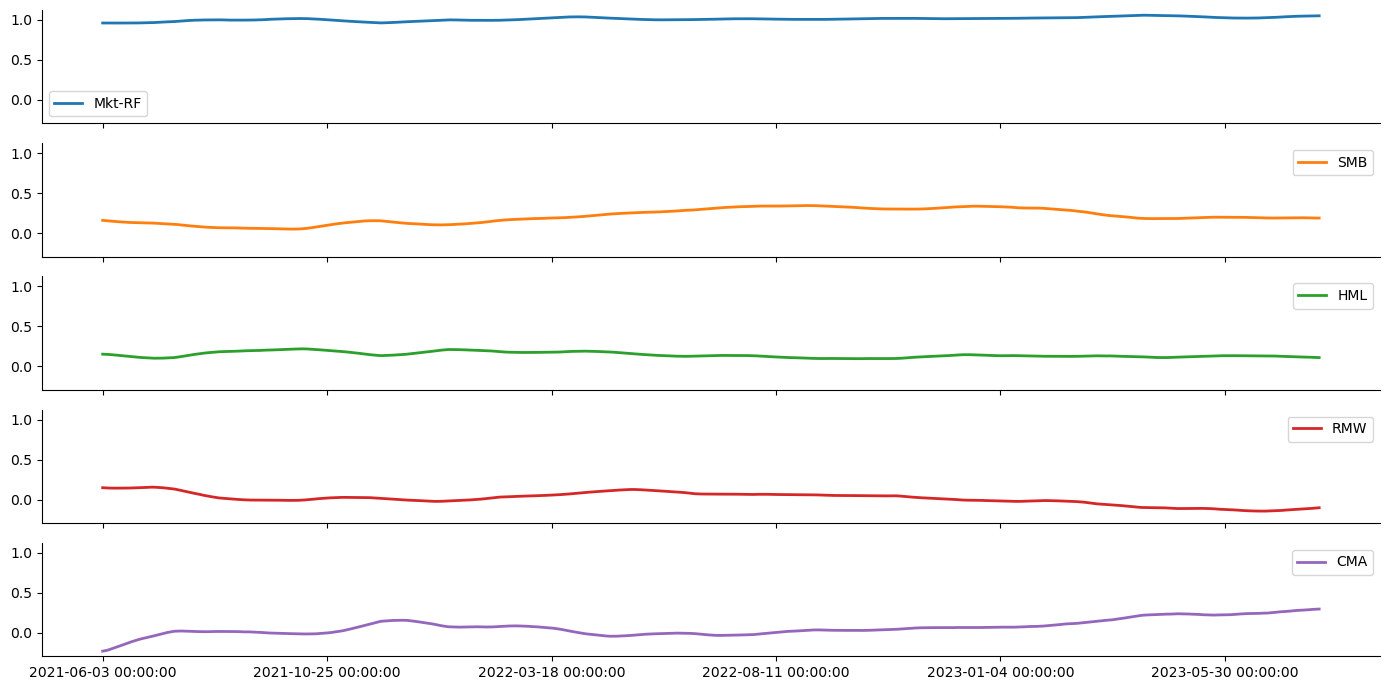

In [947]:
# change in beta over time within sample
# 90-days rolling window beta regression smoothened by 30 days moving average
import more_itertools
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# set rolling window as 3 months - for beta calculation
wind = 90
rolling_windows = list(more_itertools.windowed(stock_returns_adj.index,n=wind, step=1))
rolling_betas = {}

# multi_cols = pd.MultiIndex.from_product([stock_returns_adj.columns, ff_factor_adj.columns.tolist()])
# rolled_betas = pd.DataFrame(index=multi_cols)
multi_cols = pd.MultiIndex.from_product([['EQW_PF'], ff_factor_adj.columns.tolist()])
rolled_betas = pd.DataFrame(index=multi_cols)

for period in tqdm(rolling_windows):
    start = period[0]
    end = period[-1]
    EQW_PF_Ret = stock_returns_adj.mean(axis=1)
    EQW_PF_Ret.name = 'EQW_PF_Ret'
    returns_window = EQW_PF_Ret.loc[start:end]
    ff_factors_window = ff_factor_adj.loc[start:end]
    Betas_window = FF_betas(returns_window, ff_factors_window, single_asset=True)
    # keys expressed as the end of rolling window
    rolled_betas[str(end)] = Betas_window.values

rolled_betas = rolled_betas.T

window = 30 # smoothing with moving average
tkr = 'EQW_PF'
rolled_betas[tkr].rolling(window).mean().dropna().plot(lw=2, figsize=(14, 7), subplots=True, sharey=True)
sns.despine()
plt.tight_layout()

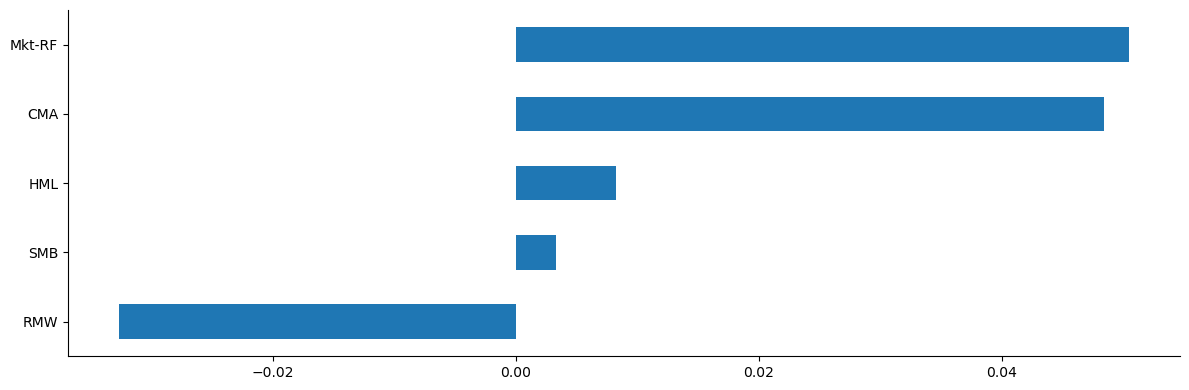

In [948]:
# Equal-weighted portfolio lambdas
stock_lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

In [949]:
# The 2-Step FFMB regression simplified in one regression with LinearFactorModel
model = LinearFactorModel(portfolios=stock_returns_adj, 
                          factors=ff_factor_adj) #, risk_free=True
res = model.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                100   R-squared:                      0.4443
No. Factors:                          5   J-statistic:                    52.337
No. Observations:                   661   P-value                         0.9999
Date:                  Mon, Oct 30 2023   Distribution:                 chi2(95)
Time:                          11:47:16                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.0505     0.0482     1.0481     0.2946     -0.0439      0.1450
SMB            0.0033     0.0445    

In [950]:
# The 2-Step FFMB regression simplified in one regression with LinearFactorModel
model = LinearFactorModel(portfolios=stock_returns_adj, 
                          factors=ff_factor_adj, risk_free=True)
res = model.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                100   R-squared:                      0.4443
No. Factors:                          5   J-statistic:                    52.162
No. Observations:                   661   P-value                         0.9999
Date:                  Mon, Oct 30 2023   Distribution:                 chi2(94)
Time:                          11:47:16                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
risk_free     -0.0494     0.0617    -0.8005     0.4234     -0.1703      0.0715
Mkt-RF         0.0998     0.0762    

In [951]:
# stock betas
res.params.T

,ABNB,ABT,AFL,ALB,ALLE,ANET,ANSS,AVGO,AWK,AXON,...,VICI,VRSK,VTRS,WDC,WELL,WRK,WTW,XYL,YUM,ZBH
alpha,-0.026629,-0.029930,0.034085,0.047667,-0.005186,0.089089,-0.030626,0.056360,-0.026800,0.058533,...,0.009472,0.013283,-0.095108,-0.095432,0.029455,-0.060093,-0.027059,-0.008476,0.021583,-0.025440
Mkt-RF,1.313424,0.749739,0.934682,1.280758,1.004116,1.182889,1.182984,1.253602,0.676522,0.873185,...,0.838528,0.737721,0.888557,1.437282,0.759194,1.150359,0.840403,1.069758,0.714765,0.794159
SMB,0.426782,-0.287232,-0.059340,0.653060,0.461139,-0.070553,-0.138956,0.031330,-0.320753,0.775655,...,0.090308,-0.129525,0.120151,0.586327,0.158562,0.532899,-0.103687,0.278219,-0.116358,0.097354
HML,-0.204563,-0.285346,0.757474,0.540196,0.055156,-0.355676,-0.576768,-0.500488,-0.339729,-0.955028,...,0.133544,-0.370527,0.407671,0.181345,0.236450,0.839941,0.050168,0.073521,0.010724,0.060370
RMW,-0.917122,0.082472,-0.047475,-0.643212,0.636775,0.093847,-0.021969,0.234616,0.315208,-0.072984,...,-0.185851,0.372464,-0.167331,0.108546,0.133995,0.376499,0.118656,0.371826,0.185707,0.034229
CMA,-0.037904,0.393229,-0.046747,-0.488727,-0.117628,-0.106019,-0.216438,0.384155,0.395484,0.266762,...,0.182285,0.098491,0.076096,0.209591,0.075256,-0.271017,0.138581,-0.083345,0.101722,0.050389


In [952]:
# actual portfolio return - expected portfolio return without risk-free rate
print('days in a year', EQW_PF_Ret.groupby(EQW_PF_Ret.index.year).count())

# in simple annual returns
EQWPF_factor_exposure = stock_betas.mean()
actual_arith_r = EQW_PF_Ret.mean() * 252
lambdas_arith_r = stock_lambdas.mean() * 252
exp_arith_r = (lambdas_arith_r * EQWPF_factor_exposure).sum()

(actual_arith_r - exp_arith_r) 

days in a year Date
2020     14
2021    252
2022    251
2023    144
Name: EQW_PF_Ret, dtype: int64


-0.442691080660369

In [953]:
# in compounded annual returns
actual_geo_r = 100 * ((1+EQW_PF_Ret/100).prod() ** (252/len(EQW_PF_Ret)) - 1)
lambda_geo_r = 100 * ((1+stock_lambdas/100).prod() ** (252/len(EQW_PF_Ret)) - 1)
exp_geo_r = sum(lambda_geo_r * EQWPF_factor_exposure)

actual_geo_r - exp_geo_r

0.18015855400115477

In [954]:
# stock lambdas with risk-free
stock_lambdas_rf = res.risk_premia

In [955]:
# actual portfolio return - expected portfolio return with risk-free rate
# in simple annual returns
EQWPF_factor_exposure = stock_betas.mean()
actual_arith_r = EQW_PF_Ret.mean() * 252
lambdas_arith_r = stock_lambdas_rf.mean() * 252
exp_arith_r = (lambdas_arith_r * EQWPF_factor_exposure).sum()

(actual_arith_r - exp_arith_r) 

7.287856121346879

In [956]:
# in compounded annual returns
actual_geo_r = 100 * ((1+EQW_PF_Ret/100).prod() ** (252/len(EQW_PF_Ret)) - 1)
lambda_geo_r = 100 * ((1+lambdas_arith_r/100).prod() ** (252/len(EQW_PF_Ret)) - 1)
exp_geo_r = sum(lambda_geo_r * EQWPF_factor_exposure)

actual_geo_r - exp_geo_r

9.193918133299897